In [1]:
# sklearn
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, accuracy_score, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

# TensorFlow
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing import sequence
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model

#GenSim
from gensim.utils import simple_preprocess
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec, KeyedVectors


#NLTK
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

#Seaborn
import seaborn as sns
import os.path

# spacy
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH

#Standards
import pandas as pd
import collections
import numpy as np
import pickle
import gensim
import spacy
import nltk
import re

# Data Cleaning

**Neccessary data preprocessing steps:**
* Remove punctuation
* Convert text to lower case
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words
* Lemmatization

### Load data

In [2]:
tweets_df = pd.read_csv('data/train.csv')

### Remove features

In [3]:
tweets_df = tweets_df.drop(['id','keyword', 'location'], axis=1)
tweets_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### Remove punctuation and convert to lower

In [4]:
#Remove Punctuation
tweets_df['text'] = tweets_df['text'].map(lambda x: re.sub('[,\.!?]', '', x))

#Convert to lower
tweets_df['text'] = tweets_df['text'].str.lower()

tweets_df.head()

,text,target
0,our deeds are the reason of this #earthquake m...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to 'shelter in place' are ...,1
3,13000 people receive #wildfires evacuation ord...,1
4,just got sent this photo from ruby #alaska as ...,1


### Tokenize 

In [5]:
tt = TweetTokenizer()
tok_words = tweets_df['text'].apply(tt.tokenize)

### Remove stopwords and lemmatization:

In [6]:
# Removing stopwords to prevent noise in the features
def remove_stopwords(texts):
    nostop_list = []
    for t in texts:
        nostop_text = [word for word in simple_preprocess(str(t)) if word not in stop_words]
        nostop_list.append(nostop_text )
    
    return nostop_list

In [7]:
# To normalize words and reduce the dimensions of our space by extracting nouns,adjectives,verbs and adverbs
def lemmatize(texts):
    is_tag = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'or pos[:2] == 'VB'or pos[:2] == 'RB'
    lem_list = []
    for t in texts:
        lem_text = [word for (word, pos) in pos_tag(t) if is_tag(pos)] 
        lem_list.append( [nlp(" ".join(lem_text))] )
    
    return lem_list

#### Remove stopwords

In [8]:
!python3 -m spacy download en_core_web_sm
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

#creating all the stopwords(commonly used words)
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject','cant','musnt', 're', 'edu', 'use','whats','havent'])

nostops_texts = remove_stopwords(tok_words)

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.6 MB 1.5 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /home/nasiem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Lemmatization

In [9]:
nltk.download('averaged_perceptron_tagger')

lem_texts = lemmatize(nostops_texts)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nasiem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Create processed dataframe

In [10]:
#Adds the processed text to the dataframe
for i in range(7613):
    tweets_df['text'] = tweets_df['text'].replace(tweets_df.text.values[i],str(lem_texts[i][0]))
    
tweets_df.head()

,text,target
0,deeds reason earthquake allah forgive,1
1,forest fire la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


In [11]:
tweets_df.to_pickle('cleaned_data.pkl')

### Load processed data

In [12]:
tweets_df = pd.read_pickle('cleaned_data.pkl')
tweets_df

,text,target
0,deeds reason earthquake allah forgive,1
1,forest fire la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...
7608,giant cranes holding bridge collapse nearby ho...,1
7609,aria_ahrary thetawniest control wild fires cal...,1
7610,utc km volcano hawaii http tco zdtoyd ebj,1
7611,police investigating bike collided car little ...,1


In [13]:
words = ' '.join([i for i in tweets_df['text']]).split()

# Create a list of all unique words for the bag of words(BOW) representation
unique_words_org = list(set(tweets_df['text'].str.replace('[^a-zA-Z ]','', regex=True).str.split(' ').sum()))

In [14]:
# All words in the text column
text_words = ' '.join([i for i in tweets_df['text']]).split()

# Keeping unique words that are found in text column
new_words = [word for word in text_words if word in unique_words_org]

# Dictionary of each word mapped to its frequency
freq = collections.Counter(new_words)

unique_words = []

#Removing words with frequency < 10
for key, value in freq.items():
    if (value > 10):
        unique_words.append(key)

In [15]:
# Create bag of words that will be used as an input to train the model
cv = CountVectorizer(max_features = len(unique_words))
bow = cv.fit_transform(tweets_df['text'].values).toarray()
#bow

In [16]:
X = bow
y = tweets_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

** **
### Logistic Regression Model
** **

#### Model fitting 

In [17]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

#### Predictions and classficication report

In [18]:
y_pred  = lr.predict(X_test)


print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       851
           1       0.81      0.71      0.76       672

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



#### Confusion matrix

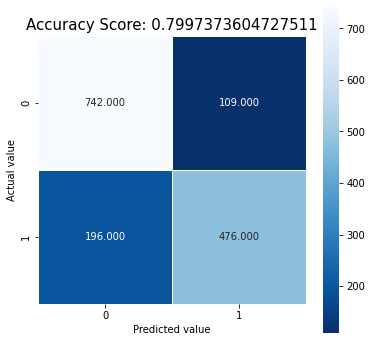

In [19]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual value');
plt.xlabel('Predicted value');
cm_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
plt.title(cm_title, size = 15);

** **
### Multinomial  Naive Bayes Classifier Model
** **

#### Model fitting 

In [20]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

#### Predictions and classficication report

In [21]:
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7747866053841103
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       851
           1       0.78      0.68      0.73       672

    accuracy                           0.77      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.77      0.77      1523



#### Confusion matrix

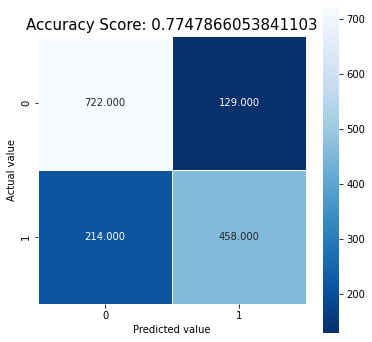

In [22]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual value');
plt.xlabel('Predicted value');
cm_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
plt.title(cm_title, size = 15);

****
### Support Vector Model
****

#### Model fitting 

In [23]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.001, max_iter=5, random_state=42, tol=None)

#### Predictions and classficication report

In [24]:
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7918581746552856
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       851
           1       0.84      0.65      0.73       672

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



#### Confusion matrix

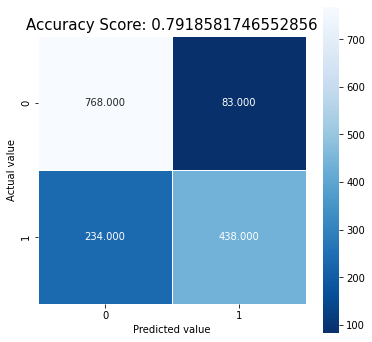

In [25]:
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual value');
plt.xlabel('Predicted value');
cm_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
plt.title(cm_title, size = 15);

** **
### LDA
** **

#### Splitting the data for LDA model

In [26]:
train_df,test_df = train_test_split(tweets_df,test_size = 0.30,stratify= tweets_df['target'])


X_train,y_train = train_df['text'],train_df['target']
X_test,y_test = test_df['text'],test_df['target']

X_train = X_train.to_frame()
X_test = X_test.to_frame()

#### Vectorize the data

In [27]:
import gensim.corpora as corpora

def data_vectorized(data_lemmatized):
    
    # Creates dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    
    # Creates corpus
    texts = data_lemmatized
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return corpus, id2word

#### Prepare the datarame of tweets for the LDA model

In [28]:
tt = TweetTokenizer()

def data_prep(df):
    
    # A list of all the preprocessed tweets
    data = list(df['text'].values)
    
    # Since the tweets have already been lemmatized, tokenization is required after lemmatization for the lda. 
    lem_texts = df['text'].apply(tt.tokenize)
    
    # Creates corpus
    corpus,id2word = data_vectorized(lem_texts)
    
    return data,lem_texts,corpus,id2word

In [29]:
#Prepares the trained data for the lda model by converting it into a bag of words.
data_T,data_lemmatized_T,corpus_T,id2word_T = data_prep(X_train)

#### Build LDA model

In [30]:
lda_model = gensim.models.LdaMulticore(corpus=corpus_T,
                                       id2word=id2word_T,
                                       num_topics=2, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

#### Prints out the dominant words per topic

In [31]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.084*"tco" + 0.077*"http" + 0.006*"û_" + 0.004*"https" + 0.004*"news" + 0.003*"video" + 0.003*"fire" + 0.003*"emergency" + 0.003*"new" + 0.003*"disaster"
Topic: 1 
Words: 0.004*"get" + 0.004*"people" + 0.004*"https" + 0.002*"know" + 0.002*"got" + 0.002*"back" + 0.002*"going" + 0.002*"life" + 0.002*"pm" + 0.002*"day"


#### Assuming topic 0 relates to non disaster events and topic 1 relates to disaster events

In [32]:
from gensim.models import CoherenceModel

# Compute Coherence Score
c_model = CoherenceModel(model=lda_model, texts=data_lemmatized_T, dictionary=id2word_T, coherence='c_v')
c_score = c_model.get_coherence()
print('Coherence score of LDA model: ', c_score)

Coherence score of LDA model:  0.3903172248574681


#### Unlike the previous models, LDA does not have an in-built predict function

#### We coded a predict function

In [33]:
# Returns the data and corpus created from test data.
def predict(X_test):
    
    data,data_lemmatized,corpus,id2word = data_prep(X_test)
    
    lda_model[corpus]
    
    return data,corpus

data, corpus = predict(X_test)

#### After obtaining the data and corpus using the test data, we needed to figure out a way to compute the accuracy.

#### We got creative and decided to use a tabular method from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus_T, texts=data_T):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

#### Table of dominant topics for each tweet/text

In [35]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8311,"get, people, https, know, got, back, going, li...",bizzlemahomie screaming
1,1,1.0,0.7000,"get, people, https, know, got, back, going, li...",latest homes razed northern california wildfir...
2,2,1.0,0.8398,"get, people, https, know, got, back, going, li...",small bag bottom wounded hero shakes senzu bea...
3,3,1.0,0.9277,"get, people, https, know, got, back, going, li...",british bake great pretty hilarious moments mu...
4,4,1.0,0.8023,"get, people, https, know, got, back, going, li...",rand paul debate strategy demolish bad ideas p...


#### Confusion matrx

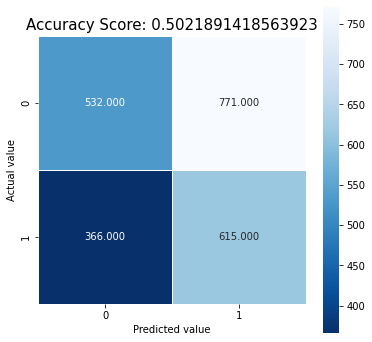

In [36]:
from sklearn.metrics import confusion_matrix

y_pred = pd.Series(df_dominant_topic['Dominant_Topic'].values.tolist(), name='Predicted')
y_actu = pd.Series(y_test.values.tolist(), name='Actual')

cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual value');
plt.xlabel('Predicted value');
cm_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test,y_pred))
plt.title(cm_title, size = 15);

In [ ]:
%%markdown
# LSTM

In [ ]:
df = pd.read_csv("data/train.csv", index_col='id')
df.head()

In [ ]:
def replace_urls(text):
    text = re.sub('http://\S+|https://\S+', ' <url> ', text)
    return text

def replace_numbers(text):
    return re.sub(r'(\d+)(?:,(\d+))*',' <number> ',text)
    

def remove_non_standard_ascii(text):
    return re.sub('[^ -~]', '', text)
    
def remove_special_chars(text):
    return re.sub('[^a-zA-z0-9\s#<>]','',text)

def clean_text(text):
    text = replace_urls(text)
    text = text.replace("&amp;","")
    text = replace_numbers(text)
    text = re.sub(r"([@])(\w+)", ' <user> ', text) # Replace mentions with dummy variable i.e. beginning with '@'
    text = re.sub("#", " # ", text)
    
    text = re.sub("\s\s+", " ", text) # Sequences of 2 or more spaces will be reduced to 1
    # Excessive Punctuation
    text = re.sub("[?][?]+", "??", text)
    text = re.sub("[!][!]+", "!!", text)
    text = re.sub("[..][.]+", "...", text)
#     text = remove_special_chars(text)
    
    return remove_non_standard_ascii(text).lower()

In [ ]:
clean_df = df.copy()
clean_df['text'] = clean_df['text'].apply(clean_text)
clean_df.shape

In [ ]:
clean_df.drop(["keyword","location"], axis = 1, inplace=True)
clean_df.head()

In [ ]:
for i in range(5):
    print(clean_df['text'].iloc[i])

In [ ]:
%%markdown
SpaCy

In [ ]:
small_df = clean_df.iloc[:100]
small_df.shape

In [ ]:
for i in range(3):
    print(small_df["text"].iloc[i])

In [ ]:
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
nlp = English()
tokenizer = nlp.tokenizer

# Add special rules 
# Number Special Case
num_special_case = [{ORTH: "<number>"}]
nlp.tokenizer.add_special_case("<number>", num_special_case)

# Url Special Case
url_special_case = [{ORTH: "<url>"}]
nlp.tokenizer.add_special_case("<url>", url_special_case)

# User Special Case
user_special_case = [{ORTH: "<user>"}]
nlp.tokenizer.add_special_case("<user>", user_special_case)

# Check new tokenization
print([w.text for w in nlp("<number> <url> <user>")])

In [ ]:
sentences = []
for doc in tokenizer.pipe(clean_df['text'], batch_size=50):
    sentences.append([str(tok) for tok in doc])

sentences[:2]

In [ ]:
%%markdown
Create Corpus

In [ ]:
corpus_word_index_freq = {"[plac]":(0,100), "[unk]":(1,100)}
# corpus_word_index_freq = {}
count = 2
for sentence in sentences:
    for word in sentence:
#         print(word, corpus_word_index)
        if word in corpus_word_index_freq:
            corpus_word_index_freq[word] = (count, corpus_word_index_freq[word][1] + 1)
        else:
            corpus_word_index_freq[word] = (count,1)
            count += 1
            
print(f"Length = {len(corpus_word_index_freq)}\n")
            
for i, key in enumerate(corpus_word_index_freq):
    if i > 5:
        break
    else:
        print(f"{key} - {corpus_word_index_freq[key]}")

In [ ]:
folder_path = "glove.twitter/glove.twitter.27B/"

embedding_vec_len = 50 # Dimensions of word vectors
glove_file_path = folder_path + "glove.twitter.27B.50d.txt" # 50 dimensional one

#Name for word2vec file
word2vec_file_path = glove_file_path+'.word2vec'

#Convert Glove embeddings to Word2Vec embeddings
glove2word2vec(glove_file_path, word2vec_file_path)

glove_model = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [ ]:
# corpus_word_index_freq
def eval_corpus_val(corpus_val):
    try:
        x = glove_model[corpus_val]
        return True
    except:
        # i.e. corpus_val is not in glove_model
        return False

In [ ]:
# min_word_freq = 1
# tmp_list = list(filter(lambda x: True if corpus_word_index_freq[x][1] >= 3 else False, corpus_word_index_freq))
tmp_list = list(filter(eval_corpus_val, corpus_word_index_freq))
tmp_list.insert(0,"[unk]")
tmp_list.insert(0,"[plac]")
corpus_index_word = {k:v for (k,v) in enumerate(tmp_list)}
corpus_word_index = {v:k for (k,v) in enumerate(tmp_list)}

In [ ]:
num_words = len(corpus_index_word)
num_words

In [ ]:
corpus_index_word[3]

In [ ]:
corpus_word_index['are']

In [ ]:
def cust_text_to_seq(sentences):
    seq = []
    for sentence in sentences:
        tmp_list = []
        for word in sentence:
            if word in corpus_word_index:
                tmp_list.append(corpus_word_index[word])
            else:
                tmp_list.append(corpus_word_index["[unk]"])
        seq.append(tmp_list)
    return seq

# print(corpus_word_index["our"])
# cust_text_to_seq(sentences)

In [ ]:
def tokenize_series(data):
    sentences = []
    for doc in tokenizer.pipe(data, batch_size=50):
        tok_str_list = [str(tok) for tok in doc]
        sentence = []
        for tok_str in tok_str_list:
            if tok_str in corpus_word_index:
                sentence.append(corpus_word_index[tok_str])
            else:
                sentence.append(corpus_word_index["[unk]"])
        sentences.append(sentence)
    return sentences

In [ ]:
%%markdown
Train-Test and Train-Validation Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_df['text'], clean_df['target'], test_size=0.20) #, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20) #, random_state=42)

In [ ]:
tmp = tokenize_series(X_train)[:2][0]
for x in tmp:
    print(corpus_index_word[x], end=" ")

In [ ]:
X_train.iloc[0]

In [ ]:
train_seq_unpad  = tokenize_series(X_train)
valid_seq_unpad  = tokenize_series(X_val)
test_seq_unpad  = tokenize_series(X_test)

In [ ]:
max(len(x) for x in train_seq_unpad)

In [ ]:
max_words = 45
max_words

In [ ]:
train_seq = sequence.pad_sequences(train_seq_unpad,maxlen=max_words,padding='post')
valid_seq = sequence.pad_sequences(valid_seq_unpad,maxlen=max_words,padding='post')
test_seq = sequence.pad_sequences(test_seq_unpad, maxlen=max_words, padding='post')

In [ ]:
train_seq
train_seq.shape

In [ ]:
%%markdown
GloVe Embedding

In [ ]:
avg_arr = np.zeros(embedding_vec_len)
for key in glove_model.vocab:
    avg_arr = avg_arr + glove_model[key] 
#     print(avg_arr)
#     print(key, glove_model[key])
#     break
avg_word_vec = avg_arr/len(glove_model.vocab)
avg_word_vec

In [ ]:
embedding_matrix = np.zeros((num_words, embedding_vec_len)) # num_words + 1 to account for unknown
embedding_matrix.shape

In [ ]:
for word in corpus_word_index:
    ind = corpus_word_index[word]
    try:
        tmp = glove_model[word]
        embedding_matrix[ind] = tmp
    except:
#         if ind != 0:
#             embedding_matrix[ind] = avg_word_vec
        pass
embedding_matrix[1]

In [ ]:
embedding_matrix.shape

In [ ]:
len(corpus_index_word)

In [ ]:
%%markdown
# LSTM Neural Net

In [ ]:
drop_rate = 0.2

tf.keras.backend.clear_session()
model = tf.keras.Sequential()

# Embedding Layer
model.add(tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                                    weights=[embedding_matrix],
                                    trainable=False, 
                                    input_length=max_words)
         )

model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.save_weights("weights/lstm_init_weights.h5")

In [ ]:
model.summary()

In [ ]:
%%markdown
# Benchmarking
## Train/Benchmark Function

In [ ]:
def train_model(_model, X_train, y_train, X_val, y_val, epochs, valid_interval, model_files_prefix, metrics_file_prefix, save_models=True):
    metric_csvs_folder = "metrics_data/"
    
    _model.load_weights("weights/lstm_init_weights.h5")
    history_dict = {}
    metrics_dict = {}

    for i in range(epochs):
        print(f"Epoch {i+1}/{epochs}")
        history_dict[i+1] = _model.fit(X_train, y_train, epochs=1, batch_size=32)
        if ((i+1)%valid_interval==0):
            if save_models:
                print(f"Saving model at 'models/{model_files_prefix}_lstm_{i+1}.h5'...")
                _model.save(f'models/{model_files_prefix}_lstm_{i+1}.h5')
            print(f"Eval on validation (epoch {i+1}):")
            valid_acc = _model.evaluate(X_val, y_val.to_numpy())
            print()
#             print(f"Valid Accuracy: {valid_acc}")
            metrics_dict[i+1] = valid_acc
            
    # Validation Metrics
    val_epochs = [epoch for epoch in metrics_dict]
    val_losses = [metrics_dict[epoch][0] for epoch in val_epochs]
    val_accs = [metrics_dict[epoch][1] for epoch in val_epochs]
    val_df_dict = {
        "epoch":val_epochs,
        "loss":val_losses,
        "acc":val_accs
    }

    val_df = pd.DataFrame.from_dict(val_df_dict)
    val_df.to_csv(f"{metric_csvs_folder}{metrics_file_prefix}_val_metrics.csv", index=False)
    
    # Train Metrics
    train_epochs = [epoch for epoch in history_dict]
    train_losses = [history_dict[epoch].history["loss"][0] for epoch in train_epochs]
    train_accs = [history_dict[epoch].history["accuracy"][0] for epoch in train_epochs]

    train_df_dict = {
        "epoch":train_epochs,
        "loss":train_losses,
        "acc":train_accs
    }

    
    train_df = pd.DataFrame.from_dict(train_df_dict)
    train_df.to_csv(f"{metric_csvs_folder}{metrics_file_prefix}_train_metrics.csv", index=False)
    
    print("---------------------------\nFinished Training!!!")
    
    return _model

In [ ]:
%%markdown
## Different Optimizers & Losses
**Losses:**
1. [Binary Cross-Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)
2. [Mean Squared Error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError)
3. [Mean Absolute Error](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError)
**Optimizers:**
1. [ADAM](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
2. [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)

In [ ]:
%%markdown
### Adam & Binary Crossentropy
Metrics:
1. train: `adam_bin_ce_train_metrics.csv`
2. valid: `adam_bin_ce_valid_metrics.csv`

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model = train_model(model, train_seq, y_train, valid_seq, y_val, 20, 5, "adam_bin_ce", "adam_bin_ce")
print("\nTesting:")
model.evaluate(test_seq, y_test.to_numpy())

In [ ]:
%%markdown
### Adam & Mean Squared Error
Metrics:
1. train: `adam_mse_train_metrics.csv`
2. valid: `adam_mse_valid_metrics.csv`

In [ ]:
model.compile(optimizer='adam',loss='MeanSquaredError',metrics=['accuracy'])
model = train_model(model, train_seq, y_train, valid_seq, y_val, 20, 5, "adam_mse", "adam_mse")
print("\nTesting:")
model.evaluate(test_seq, y_test.to_numpy())

In [ ]:
%%markdown
### Adam & Poisson
Metrics:
1. train: `adam_poisson_train_metrics.csv`
2. valid: `adam_poisson_valid_metrics.csv`

In [ ]:
model.compile(optimizer='adam',loss='poisson',metrics=['accuracy'])
model = train_model(model, train_seq, y_train, valid_seq, y_val, 20, 5, "adam_poisson", "adam_poisson")
print("\nTesting:")
model.evaluate(test_seq, y_test.to_numpy())

In [ ]:
%%markdown
### Adam & Mean Absolute Error
Metrics:
1. train: `adam_mae_train_metrics.csv`
2. valid: `adam_mae_valid_metrics.csv`

In [ ]:
model.compile(optimizer='adam',loss='MeanAbsoluteError',metrics=['accuracy'])
model = train_model(model, train_seq, y_train, valid_seq, y_val, 20, 5, "adam_mae", "adam_mae")
print("\nTesting:")
model.evaluate(test_seq, y_test.to_numpy())

In [ ]:
%%markdown
### SGD & Binary Crossentropy
Metrics:
1. train: `sgd_bin_ce_train_metrics.csv`
2. valid: `sgd_bin_ce_valid_metrics.csv`

In [ ]:
model.compile(optimizer='SGD',loss='binary_crossentropy',metrics=['accuracy'])
model = train_model(model, train_seq, y_train, valid_seq, y_val, 30, 5, "sgd_bin_ce", "sgd_bin_ce")
print("\nTesting:")
model.evaluate(test_seq, y_test.to_numpy())

In [ ]:
%%markdown
### SGD & Mean Squared Error
Metrics:
1. train: `sgd_mse_train_metrics.csv`
2. valid: `sgd_mse_valid_metrics.csv`

In [ ]:
model.compile(optimizer='SGD',loss='MeanSquaredError',metrics=['accuracy'])
model = train_model(model, train_seq, y_train, valid_seq, y_val, 20, 5, "sgd_mse", "sgd_mse")
print("\nTesting:")
model.evaluate(test_seq, y_test.to_numpy())

In [ ]:
%%markdown
### Conclusion
Adam & Poisson seem to do the best
## Differing Word Vector Size
1. size = 25
2. size = 50
3. size = 100
4. size = 200

In [ ]:
folder_path = "glove.twitter/glove.twitter.27B/"

embedding_vec_len_list = [25,50,100,200]
word2vec_file_path_list = []

# os.path.isfile(path)

# create .word2vec files if required
for embedding_vec_len in embedding_vec_len_list:
    glove_file_path = folder_path + f"glove.twitter.27B.{embedding_vec_len}d.txt"
    word2vec_file_path = glove_file_path+'.word2vec'
    word2vec_file_path_list.append(word2vec_file_path)
    if not os.path.isfile(word2vec_file_path):
        glove2word2vec(glove_file_path, word2vec_file_path)
        
word2vec_file_path_list

In [ ]:
embedding_matrix_dict = {}

for embedding_vec_len, word2vec_file_path in zip(embedding_vec_len_list, word2vec_file_path_list):
    print(f"Creating embedding matrix for embedding_vec_len = {embedding_vec_len}...")
    glove_model = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=False) #, no_header=True)
    embedding_matrix = np.zeros((num_words + 1, embedding_vec_len)) # num_words + 1 to account for unknown

    
    avg_arr = np.zeros(embedding_vec_len)
    for key in glove_model.vocab:
        avg_arr = avg_arr + glove_model[key] 

    avg_word_vec = avg_arr/len(glove_model.vocab)
    
    for word in corpus_word_index:
        ind = corpus_word_index[word]
        try:
            tmp = glove_model[word]
            embedding_matrix[ind] = tmp
        except:
            pass

            
    embedding_matrix_dict[embedding_vec_len] = embedding_matrix
    
print("All embedding matrices created!")

In [ ]:
embedding_matrix_dict

In [ ]:
for embedding_vec_len in embedding_matrix_dict:
#     print(embedding_vec_len)
#     print(embedding_matrix_dict[embedding_vec_len])    
    embedding_matrix = embedding_matrix_dict[embedding_vec_len]
    
    drop_rate = 0.2

    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Embedding Layer
    model.add(tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                                        weights=[embedding_matrix],
                                        trainable=False, 
                                        input_length=max_words)
             )

    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.LSTM(256))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    model.save_weights("weights/lstm_init_weights.h5")
    
    print(f"\n#################################")
    print(f"#   EMBEDDING VECTOR LENGTH     #")
    print(f"#           {embedding_vec_len:3}                 #")
    print(f"#################################")
    print(model.summary())
    print("\n###\n")
    
    model.compile(optimizer='adam',loss='poisson',metrics=['accuracy'])
    model = train_model(model, train_seq, y_train, valid_seq, y_val, 20, 5, f"vec_len_{embedding_vec_len}", f"vec_len_{embedding_vec_len}")
    print("\nTESTING:")
    model.evaluate(test_seq, y_test.to_numpy())

In [ ]:
%%markdown
## Different LSTM Layer Size

In [ ]:
lstm_layer_size_list = [128,256,512]
evals = {}
for lstm_layer_size in lstm_layer_size_list:
#     print(embedding_vec_len)
#     print(embedding_matrix_dict[embedding_vec_len])    
    embedding_matrix = embedding_matrix_dict[100]
    
    drop_rate = 0.2

    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Embedding Layer
    model.add(tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                                        weights=[embedding_matrix],
                                        trainable=False, 
                                        input_length=max_words)
             )

    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.LSTM(lstm_layer_size))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    model.save_weights("weights/lstm_init_weights.h5")
    
    print(f"\n#################################")
    print(f"#       LSTM LAYER SIZE         #")
    print(f"#           {lstm_layer_size:3}                 #")
    print(f"#################################")
    print(model.summary())
    print("\n###\n")
    
    model.compile(optimizer='adam',loss='poisson',metrics=['accuracy'])
    model = train_model(model, train_seq, y_train, valid_seq, y_val, 20, 5, f"lstm_layer_size_{lstm_layer_size}", f"lstm_layer_size_{lstm_layer_size}")
    
    print("\nTESTING:")
    final_eval = model.evaluate(test_seq, y_test.to_numpy())
    evals[lstm_layer_size] = final_eval
    
print("\n###########")
print("# SUMMARY #")
print("###########")
for lstm_layer_size in evals:
    print(f"Drop Rate: {lstm_layer_size} => Test Loss: {round(evals[lstm_layer_size][0], 3)}. Test Accuracy: {round(evals[lstm_layer_size][1], 3)}")

In [ ]:
%%markdown
## Different Dropout Values 

In [ ]:
drop_rate_list = [0, 0.1, 0.2, 0.3] # 0 signifies no dropout
evals = {}
for drop_rate in drop_rate_list:
#     print(embedding_vec_len)
#     print(embedding_matrix_dict[embedding_vec_len])    
    embedding_matrix = embedding_matrix_dict[50]

    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # Embedding Layer
    model.add(tf.keras.layers.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                                        weights=[embedding_matrix],
                                        trainable=False, 
                                        input_length=max_words)
             )

    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.LSTM(256))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    model.save_weights("weights/lstm_init_weights.h5")
    
    print("")
    print(f"#################################")
    print(f"#         DROP RATE             #")
    print(f"#            {drop_rate:3}                #")
    print(f"#################################")
    print(model.summary())
    print("\nTraining...\n")
    
    model.compile(optimizer='adam',loss='poisson',metrics=['accuracy'])
    model = train_model(model, train_seq, y_train, valid_seq, y_val, 20, 5, f"drop_rate_{drop_rate}", f"drop_rate_{drop_rate}")
    print("\nTESTING:")
    final_eval = model.evaluate(test_seq, y_test.to_numpy())
    evals[drop_rate] = final_eval
    
print("\n###########")
print("# SUMMARY #")
print("###########")
for drop_rate in evals:
    print(f"Drop Rate: {drop_rate} => Test Loss: {round(evals[drop_rate][0], 3)}. Test Accuracy: {round(evals[drop_rate][1], 3)}")

In [ ]:
pd.read_csv("metrics_data/adam_bin_ce_train_metrics.csv")

In [ ]:
%%markdown
## Evaluate Saved Models
### Evaluate On Test Data

In [ ]:
model_names = list(filter(lambda x: False if x==".gitignore" else True, os.listdir("models")))
evals_dict = {}

for i, model_name in enumerate(model_names):
    print(f"[{i+1}/{len(model_names)}] Evaluating {model_name}...")
    curr_model = load_model(f"models/{model_name}")
    evals_dict[model_name] = curr_model.evaluate(valid_seq, y_val.to_numpy())

In [ ]:
acc_sorted_keys = sorted(evals_dict, key = lambda x: evals_dict[x][1], reverse=True)
acc_sorted_tups = [(key, evals_dict[key][1]) for key in acc_sorted_keys]
print(acc_sorted_tups)


test_df = pd.DataFrame.from_dict(acc_sorted_tups)
test_df.to_csv(f"Test_ACC/data_test_metrics.csv", index=False)

In [ ]:
model = load_model(f"models/lstm_layer_size_128_lstm_10.h5")
y_pred = model.predict(valid_seq)
# print(valid_seq.shape, y_val.to_numpy().shape)
print(y_pred)
print(y_val.to_numpy())

In [ ]:

def func(x):
    if x < 0.5:
        return 0
    else:
        return 1

y_pred = np.array(list(map(func, y_pred)))
y_pred

In [ ]:
cm = metrics.confusion_matrix(y_val.to_numpy(), y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual value');
plt.xlabel('Predicted value');
cm_title = 'Accuracy Score: {0}'.format(accuracy_score(y_val.to_numpy(),y_pred))
plt.title(cm_title, size = 15);
plt.savefig("LSTM.png")
plt.show()
